In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns 

from sklearn.cross_decomposition import PLSRegression
from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# --- CONFIG ---
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# --- LOAD FROM CACHE OR FETCH ---
if os.path.exists(tickers_csv_file):
    print("Loading tickers from CSV cache...")
    df_sp500 = pd.read_csv(tickers_csv_file)
else:
    print("Fetching tickers from API...")
    url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"
    df_sp500 = pd.DataFrame(requests.get(url).json())

    # Save to CSV
    df_sp500.to_csv(tickers_csv_file, index=False)
    print(f"Saved {len(df_sp500)} tickers to CSV cache.")

    
tickers = df_sp500["symbol"].dropna().unique().tolist()
# --- PREVIEW ---
print(df_sp500.shape)
print(df_sp500.columns)
print(df_sp500.head(5))

Loading tickers from CSV cache...
(503, 8)
Index(['symbol', 'name', 'sector', 'subSector', 'headQuarter',
       'dateFirstAdded', 'cik', 'founded'],
      dtype='object')
  symbol                  name                  sector  \
0    XYZ           Block, Inc.              Technology   
1    TTD  The Trade Desk, Inc.              Technology   
2   DDOG               Datadog              Technology   
3   COIN       Coinbase Global      Financial Services   
4   DASH              DoorDash  Communication Services   

                            subSector              headQuarter dateFirstAdded  \
0           Software - Infrastructure      Oakland, California     2025-07-23   
1              Software - Application      Ventura, California     2025-07-18   
2              Software - Application  New York City, New York     2025-07-09   
3  Financial - Data & Stock Exchanges     Wilmington, Delaware     2025-05-19   
4      Internet Content & Information        San Francisco, CA     2025-03

In [3]:
# --- CONFIG ---
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# Load tickers
df_sp500 = pd.read_csv(tickers_csv_file)
tickers = df_sp500["symbol"].dropna().unique().tolist()

# Output file
output_file = os.path.join(data_folder, "price_and_earnings.json")

def fetch_price_and_earnings(tickers, output_file):
    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        return pd.DataFrame(json.load(open(output_file)))

    records = []
    for ticker in tickers:
        try:
            # Get current price
            quote_url = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?apikey={API_KEY}"
            price_data = requests.get(quote_url).json()
            if not price_data:
                continue
            price = price_data[0]["price"]

            # Get latest annual income statement (EPS or netIncome)
            income_url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}"
            income_data = requests.get(income_url).json()
            if not income_data:
                continue
            eps = income_data[0].get("eps")
            net_income = income_data[0].get("netIncome")

            records.append({
                "symbol": ticker,
                "price": price,
                "eps": eps,
                "netIncome": net_income
            })

        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(0.2)  # polite rate limit

    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")

    return pd.DataFrame(records)

price_earnings_df = fetch_price_and_earnings(tickers, output_file)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/price_and_earnings.json


In [4]:
# Only keep rows with positive EPS
pe_data = price_earnings_df[price_earnings_df["eps"] > 0].copy()

# Compute log(PE)
pe_data["log_PE"] = np.log(pe_data["price"] / pe_data["eps"])

# Optional: store just the series if you want
pe_series = pe_data["log_PE"]

# Print row count for reference
print(f"Rows used: {len(pe_series)}")
print(pe_series.head())

# we are only pulling the eps and takingthe log here.. the code that follows doesn't immediately and directly build on this code 

Rows used: 480
0    2.741115
1    4.033134
2    5.514162
3    3.434049
4    6.756855
Name: log_PE, dtype: float64


## break 

In [5]:
def fetch_statement(endpoint, tickers, period, limit, data_folder):
    """Fetch statements with unique JSON filename based on endpoint, period, limit."""
    output_file = os.path.join(
        data_folder,
        f"{endpoint}_{period}_limit{limit}.json"
    )

    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        with open(output_file, "r") as f:
            return json.load(f)

    records = []
    for ticker in tickers:
        url = f"https://financialmodelingprep.com/api/v3/{endpoint}/{ticker}?period={period}&limit={limit}&apikey={API_KEY}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                for row in data:
                    row["symbol"] = ticker
                records.extend(data)
        except Exception as e:
            print(f"Error fetching {ticker} ({endpoint}): {e}")
        time.sleep(.2)  # API polite rate limit

    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")
    return records


income_data_2_years   = fetch_statement("income-statement", tickers, "annual", 2, data_folder)
balance_data_2_years  = fetch_statement("balance-sheet-statement", tickers, "annual", 2, data_folder)
cashflow_data_2_years = fetch_statement("cash-flow-statement", tickers, "annual", 2, data_folder)

# Convert to DataFrames
income_data_2_years   = pd.DataFrame(income_data_2_years)
balance_data_2_years  = pd.DataFrame(balance_data_2_years)
cashflow_data_2_years = pd.DataFrame(cashflow_data_2_years)

print("Income shape:", income_data_2_years.shape)
print("Balance shape:", balance_data_2_years.shape)
print("Cash flow shape:", cashflow_data_2_years.shape)

print(income_data_2_years.columns)
print(balance_data_2_years.columns)
print(cashflow_data_2_years.columns)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/income-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/balance-sheet-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/cash-flow-statement_annual_limit2.json
Income shape: (1006, 38)
Balance shape: (1006, 54)
Cash flow shape: (1006, 40)
Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
  

In [6]:
def sort_by_symbol_date(df):
    return df.sort_values(["symbol", "date"])


def compute_yoy_growth(df, exclude_cols=["symbol", "date","link","finalLink"]):
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
    
    df_growth = df.copy()
    for col in numeric_cols:
        df_growth[col + "_yoy"] = df.groupby("symbol")[col].pct_change()
    
    return df_growth


income_sorted = sort_by_symbol_date(income_data_2_years)
balance_sorted = sort_by_symbol_date(balance_data_2_years)
cashflow_sorted = sort_by_symbol_date(cashflow_data_2_years)

income_growth = compute_yoy_growth(income_sorted)
balance_growth = compute_yoy_growth(balance_sorted)
cashflow_growth = compute_yoy_growth(cashflow_sorted)


#we are sorting to make sure that hte dates are properly aligned before we perform out pct chagne method 

In [7]:
def count_zeros_nans_yoy(df):
    # Keep only numeric columns that end with "_yoy"
    numeric_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    
    # Count zeros and NaNs
    zero_counts = (df[numeric_cols] == 0).sum()
    nan_counts = df[numeric_cols].isna().sum()
    
    # Combine into a single DataFrame
    summary = pd.DataFrame({
        "zeros": zero_counts,
        "nans": nan_counts
    }).sort_values(by=["zeros", "nans"], ascending=True)
    
    # Force full display
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        print(summary)
    
    return summary

# Example usage
print("Income 0/NaN counts per YoY column:")
income_summary = count_zeros_nans_yoy(income_growth)

print("\nBalance 0/NaN counts per YoY column:")
balance_summary = count_zeros_nans_yoy(balance_growth)

print("\nCashflow 0/NaN counts per YoY column:")
cashflow_summary = count_zeros_nans_yoy(cashflow_growth)

# the purpose here is to make it easy to identify which line items (columns) are fully filled out from our sample so that we are only grabbing columns (features)
# that are likely to be filled out by the stock under consideration, cause ultimately after we find a regression that has explanatory power... we can still only apply it 
# to the stock under consideration if it has the same line items filled out 
# the 503 nans is a result of the .pct change method that we used which creates a nan on every other row

Income 0/NaN counts per YoY column:
                                             zeros  nans
revenue_yoy                                      0   503
grossProfit_yoy                                  0   503
costAndExpenses_yoy                              0   503
ebitdaratio_yoy                                  0   503
operatingIncome_yoy                              0   503
operatingIncomeRatio_yoy                         0   503
incomeBeforeTax_yoy                              0   503
incomeBeforeTaxRatio_yoy                         0   503
netIncomeRatio_yoy                               0   503
ebitda_yoy                                       0   504
operatingExpenses_yoy                            0   507
costOfRevenue_yoy                                0   510
totalOtherIncomeExpensesNet_yoy                  0   535
generalAndAdministrativeExpenses_yoy             0   756
netIncome_yoy                                    1   503
eps_yoy                                          1  

In [8]:
def remove_single_period_features(df, nan_threshold=503, keep_cols=["symbol","date"], name=""):
    """Select _yoy numeric columns, replace inf, drop rows/columns with too many NaNs."""
    yoy_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    sub_df = df[yoy_cols + keep_cols].copy()  # Keep symbol/date columns
    
    # Drop columns with too many NaNs (only apply to yoy columns)
    valid_yoy_cols = [c for c in yoy_cols if sub_df[c].isna().sum() <= nan_threshold]
    sub_df = sub_df[valid_yoy_cols + keep_cols]
    
    # Replace infinities with NaN and drop rows with any remaining NaNs (only apply to yoy columns)
    sub_df[valid_yoy_cols] = sub_df[valid_yoy_cols].replace([np.inf, -np.inf], np.nan)
    sub_df.dropna(subset=valid_yoy_cols, inplace=True)
    
    print(f"{name} cleaned shape: {sub_df.shape}")
    return sub_df

# Step 0: Clean _yoy columns and print shapes
income_post_nans = remove_single_period_features(income_growth, name="Income")
balance_post_nans = remove_single_period_features(balance_growth, name="Balance")
cashflow_post_nans = remove_single_period_features(cashflow_growth, name="Cashflow")


Income cleaned shape: (502, 17)
Balance cleaned shape: (502, 12)
Cashflow cleaned shape: (501, 12)


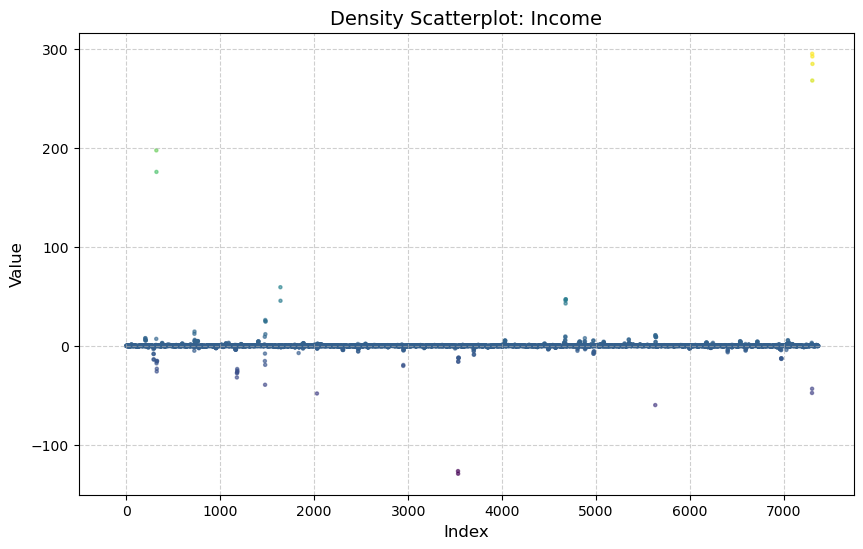

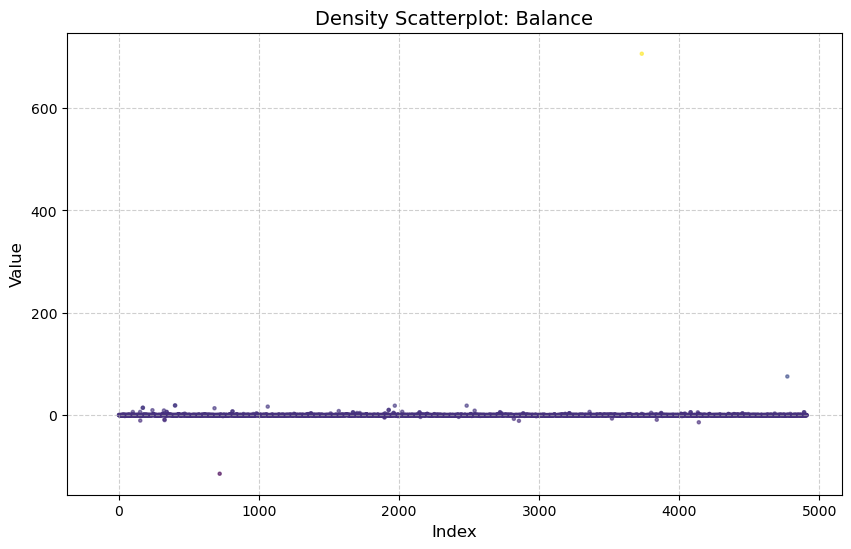

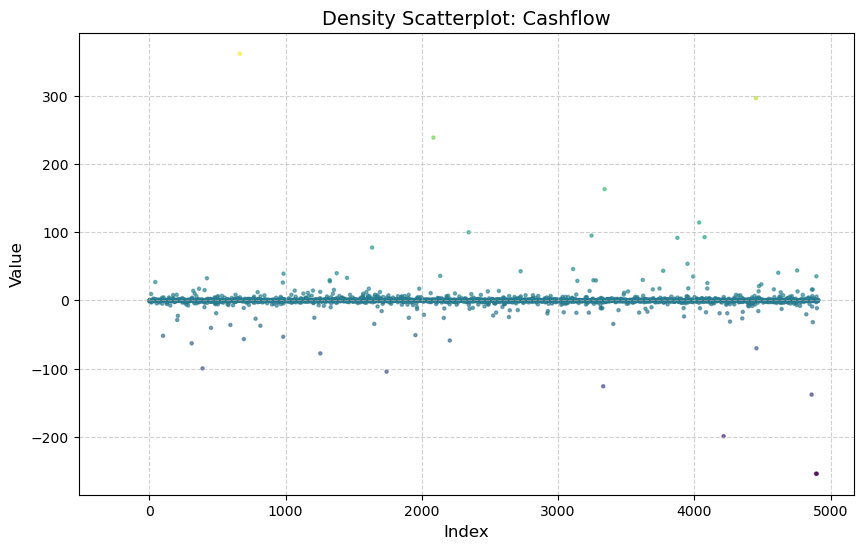

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_density_scatter(df, title):
    # Flatten all numeric columns into one long vector
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns
    values = df[numeric_cols].values.flatten()
    values = values[~np.isnan(values)]  # drop NaNs

    # Scatter vs. index, colored by density
    plt.figure(figsize=(10, 6))
    sns.kdeplot(values, fill=True, color="lightblue", alpha=0.3, linewidth=0)  # background density
    plt.scatter(range(len(values)), values, 
                c=values, cmap="viridis", s=5, alpha=0.6)

    plt.title(f"Density Scatterplot: {title}", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Call for each of your cleaned DataFrames
plot_density_scatter(income_post_nans, "Income")
plot_density_scatter(balance_post_nans, "Balance")
plot_density_scatter(cashflow_post_nans, "Cashflow")


In [9]:
# Step 1: Keep only common (symbol, date) pairs
for df in [income_post_nans, balance_post_nans, cashflow_post_nans]:
    df["symbol_date"] = list(zip(df["symbol"], df["date"]))

common_pairs = (
    set(income_post_nans["symbol_date"])
    & set(balance_post_nans["symbol_date"])
    & set(cashflow_post_nans["symbol_date"])
)

income_post_nans = income_post_nans[income_post_nans["symbol_dat
                                                     e"].isin(common_pairs)].copy()
balance_post_nans = balance_post_nans[balance_post_nans["symbol_date"].isin(common_pairs)].copy()
cashflow_post_nans = cashflow_post_nans[cashflow_post_nans["symbol_date"].isin(common_pairs)].copy()

# we only want to include a ticker if we have all the financial statement items for all three financial statements 

In [10]:
# Step 2: Sort consistently
income_post_nans = income_post_nans.sort_values(["symbol","date"]).reset_index(drop=True)
balance_post_nans = balance_post_nans.sort_values(["symbol","date"]).reset_index(drop=True)
cashflow_post_nans = cashflow_post_nans.sort_values(["symbol","date"]).reset_index(drop=True)

print("Cleaned and aligned shapes:", income_post_nans.shape, balance_post_nans.shape, cashflow_post_nans.shape)

Cleaned and aligned shapes: (491, 18) (491, 13) (491, 13)


In [11]:
# Step 1: Clean & align by (symbol, date)
def clean_and_align(dfs, nan_threshold=503, keep_cols=["symbol","date"]):
    """
    1) Drop columns with too many NaNs
    2) Replace inf with NaN
    3) Drop rows with any remaining NaNs
    4) Align multiple DataFrames by shared (symbol, date) rows
    """
    cleaned = {}
    for name, df in dfs.items():
        # Select _yoy numeric columns
        yoy_cols = [c for c in df.select_dtypes(include=[float,int]).columns if c.endswith("_yoy")]
        # Keep only valid columns under nan_threshold
        valid_cols = [c for c in yoy_cols if df[c].isna().sum() <= nan_threshold]
        sub_df = df[valid_cols + keep_cols].copy()
        
        # Replace infs with NaN and drop rows with any remaining NaNs
        sub_df[valid_cols] = sub_df[valid_cols].replace([np.inf, -np.inf], np.nan)
        before = sub_df.shape[0]
        sub_df.dropna(subset=valid_cols, inplace=True)
        after = sub_df.shape[0]
        print(f"{name}: {before - after} rows dropped due to NaNs")
        
        # Create composite key
        sub_df["symbol_date"] = list(zip(sub_df["symbol"], sub_df["date"]))
        cleaned[name] = sub_df
        print(f"{name} shape after cleaning: {sub_df.shape}")
    
    # Find shared (symbol, date) across all dfs
    common_pairs = set.intersection(*(set(df["symbol_date"]) for df in cleaned.values()))
    print(f"Shared (symbol, date) rows across all dfs: {len(common_pairs)}")
    
    # Filter each df to shared rows
    aligned = {name: df[df["symbol_date"].isin(common_pairs)].copy().reset_index(drop=True) 
               for name, df in cleaned.items()}
    
    # Drop helper column
    for df in aligned.values():
        df.drop(columns=["symbol_date"], inplace=True)
    
    return aligned, common_pairs

In [12]:
aligned, common_pairs = clean_and_align({
    "income": income_post_nans,
    "balance": balance_post_nans,
    "cashflow": cashflow_post_nans
})

income: 0 rows dropped due to NaNs
income shape after cleaning: (491, 18)
balance: 0 rows dropped due to NaNs
balance shape after cleaning: (491, 13)
cashflow: 0 rows dropped due to NaNs
cashflow shape after cleaning: (491, 13)
Shared (symbol, date) rows across all dfs: 491


In [13]:
print(income_post_nans.columns)
print(balance_post_nans.columns)
print(cashflow_post_nans.columns)

Index(['revenue_yoy', 'grossProfit_yoy', 'grossProfitRatio_yoy',
       'costAndExpenses_yoy', 'ebitdaratio_yoy', 'operatingIncome_yoy',
       'operatingIncomeRatio_yoy', 'incomeBeforeTax_yoy',
       'incomeBeforeTaxRatio_yoy', 'netIncome_yoy', 'netIncomeRatio_yoy',
       'eps_yoy', 'epsdiluted_yoy', 'weightedAverageShsOut_yoy',
       'weightedAverageShsOutDil_yoy', 'symbol', 'date', 'symbol_date'],
      dtype='object')
Index(['cashAndCashEquivalents_yoy', 'cashAndShortTermInvestments_yoy',
       'otherNonCurrentAssets_yoy', 'totalAssets_yoy', 'totalLiabilities_yoy',
       'totalStockholdersEquity_yoy', 'totalEquity_yoy',
       'totalLiabilitiesAndStockholdersEquity_yoy',
       'totalLiabilitiesAndTotalEquity_yoy', 'netDebt_yoy', 'symbol', 'date',
       'symbol_date'],
      dtype='object')
Index(['netIncome_yoy', 'changeInWorkingCapital_yoy',
       'netCashProvidedByOperatingActivities_yoy',
       'netCashUsedForInvestingActivites_yoy',
       'netCashUsedProvidedByFinanci

In [14]:
for name, df in {"income": income_post_nans, "balance": balance_post_nans, "cashflow": cashflow_post_nans}.items():
    print(f"\n{name.upper()} FIRST 5 SYMBOLS:")
    print(df["symbol"].head(5).to_list())
    print(f"\n{name.upper()} LAST 5 SYMBOLS:")
    print(df["symbol"].tail(5).to_list())
    
# just a check that the symbols are the same and aligned 


INCOME FIRST 5 SYMBOLS:
['AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL']

INCOME LAST 5 SYMBOLS:
['XYZ', 'YUM', 'ZBH', 'ZBRA', 'ZTS']

BALANCE FIRST 5 SYMBOLS:
['AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL']

BALANCE LAST 5 SYMBOLS:
['XYZ', 'YUM', 'ZBH', 'ZBRA', 'ZTS']

CASHFLOW FIRST 5 SYMBOLS:
['AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL']

CASHFLOW LAST 5 SYMBOLS:
['XYZ', 'YUM', 'ZBH', 'ZBRA', 'ZTS']


In [15]:
def run_pca_with_prefix(df, n_components=None, prefix=""):
    """
    Run PCA on a DataFrame, return DataFrame of PCs with prefixed column names.
    """
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(df)
    
    col_names = [f"{prefix}PC{i+1}" for i in range(pcs.shape[1])]
    pcs_df = pd.DataFrame(pcs, columns=col_names, index=df.index)
    return pcs_df

In [16]:
print(income_post_nans.dtypes)
print(balance_post_nans.dtypes)
print(cashflow_post_nans.dtypes)


revenue_yoy                     float64
grossProfit_yoy                 float64
grossProfitRatio_yoy            float64
costAndExpenses_yoy             float64
ebitdaratio_yoy                 float64
operatingIncome_yoy             float64
operatingIncomeRatio_yoy        float64
incomeBeforeTax_yoy             float64
incomeBeforeTaxRatio_yoy        float64
netIncome_yoy                   float64
netIncomeRatio_yoy              float64
eps_yoy                         float64
epsdiluted_yoy                  float64
weightedAverageShsOut_yoy       float64
weightedAverageShsOutDil_yoy    float64
symbol                           object
date                             object
symbol_date                      object
dtype: object
cashAndCashEquivalents_yoy                   float64
cashAndShortTermInvestments_yoy              float64
otherNonCurrentAssets_yoy                    float64
totalAssets_yoy                              float64
totalLiabilities_yoy                         float64
t

In [17]:
def drop_non_numeric(df):
    """Keep only numeric columns."""
    return df.select_dtypes(include=[np.number])


In [18]:
income_pcs = run_pca_with_prefix(income_post_nans.drop(columns=["symbol","date"], errors="ignore"), 
                                 n_components=3, prefix="income_")
balance_pcs = run_pca_with_prefix(balance_post_nans.drop(columns=["symbol","date"], errors="ignore"), 
                                  n_components=3, prefix="balance_")
cashflow_pcs = run_pca_with_prefix(cashflow_post_nans.drop(columns=["symbol","date"], errors="ignore"), 
                                   n_components=3, prefix="cashflow_")


ValueError: setting an array element with a sequence.

In [ ]:
income_cols = ["revenue_yoy","netIncome_yoy","operatingIncomeRatio_yoy"]
balance_cols = ["totalAssets_yoy","totalLiabilities_yoy","totalStockholdersEquity_yoy"]
cashflow_cols = ["operatingCashFlow_yoy","freeCashFlow_yoy","netCashProvidedByOperatingActivities_yoy"]

income_pcs, income_pca_model = run_pca(aligned["income"], income_cols, n_components=3)
balance_pcs, balance_pca_model = run_pca(aligned["balance"], balance_cols, n_components=3)
cashflow_pcs, cashflow_pca_model = run_pca(aligned["cashflow"], cashflow_cols, n_components=3)

In [ ]:
income_pcs["symbol"] = aligned["income"]["symbol"].values
balance_pcs["symbol"] = aligned["balance"]["symbol"].values
cashflow_pcs["symbol"] = aligned["cashflow"]["symbol"].values

print(cashflow_pcs.shape)
print(balance_pcs.shape)
print(income_pcs.shape)

cashflow_pcs.columns   
pe_data.shape

In [ ]:
all_pcs = pd.concat(
    [income_pcs, balance_pcs, cashflow_pcs], axis=1
)

all_pcs = all_pcs.loc[:, ~all_pcs.columns.duplicated()]


merged = pd.merge(all_pcs, pe_data[["symbol", "log_PE"]], on="symbol")
print("Merged shape:", merged.shape)

merged.head(4)

In [ ]:
# Assume merged has all the features and log_PE
X = merged.drop(columns=["symbol", "log_PE"])
y = merged["log_PE"]

# Add a constant for intercept
X_const = sm.add_constant(X)

# Create quartiles based on log_PE
merged["PE_quartile"] = pd.qcut(merged["log_PE"], 4, labels=False)  # 0=lowest, 3=highest

# Prepare a DataFrame to store results
results_df = pd.DataFrame()

# Loop through quartiles
for q in range(4):
    mask = merged["PE_quartile"] == q
    X_q = X_const[mask]
    y_q = y[mask]
    
    model_q = sm.OLS(y_q, X_q).fit()
    
    # Store coefficients and standard errors
    coef_df = pd.DataFrame({
        "variable": model_q.params.index,
        "coef": model_q.params.values,
        "std_err": model_q.bse.values,
        "R_squared": model_q.rsquared,
        "quartile": q+1  # human-friendly 1-4
    })
    
    results_df = pd.concat([results_df, coef_df], ignore_index=True)

# Show results
print(results_df)

In [ ]:
# --- Precompute numeric response ---
y = merged["log_PE"].astype(float)

# --- Define PCA column groups with prefixes ---
income_pcs_cols_prefixed = [f"income_{c}" for c in merged.columns if c in income_pcs.columns]
balance_pcs_cols_prefixed = [f"balance_{c}" for c in merged.columns if c in balance_pcs.columns]
cashflow_pcs_cols_prefixed = [f"cashflow_{c}" for c in merged.columns if c in cashflow_pcs.columns]

# Add prefixed columns to merged temporarily
merged_prefixed = pd.concat([
    merged[[c for c in merged.columns if c in income_pcs.columns]].add_prefix("income_"),
    merged[[c for c in merged.columns if c in balance_pcs.columns]].add_prefix("balance_"),
    merged[[c for c in merged.columns if c in cashflow_pcs.columns]].add_prefix("cashflow_")
], axis=1)

# Keep only numeric columns
merged_prefixed = merged_prefixed.select_dtypes(include=[np.number])

# --- Hyperparameter loop ---
results = []

for k_income in range(1, len(income_pcs_cols_prefixed)+1):
    for k_balance in range(1, len(balance_pcs_cols_prefixed)+1):
        for k_cashflow in range(1, len(cashflow_pcs_cols_prefixed)+1):
            
            # Subset first k PCs for each category
            X_subset = pd.concat([
                merged_prefixed[income_pcs_cols_prefixed[:k_income]],
                merged_prefixed[balance_pcs_cols_prefixed[:k_balance]],
                merged_prefixed[cashflow_pcs_cols_prefixed[:k_cashflow]]
            ], axis=1)
            
            # Add intercept
            X_subset = sm.add_constant(X_subset)

            # Fit OLS
            model = sm.OLS(y, X_subset).fit()

            # Print R²
            print(f"Income {k_income}, Balance {k_balance}, Cashflow {k_cashflow}, R²: {model.rsquared:.3f}")

            # Print coefficients and t-stats
            for var in model.params.index:
                print(f"  {var}: coef = {model.params[var]:.4f}, t-stat = {model.tvalues[var]:.3f}")

            # Store results
            res = {
                "k_income": k_income,
                "k_balance": k_balance,
                "k_cashflow": k_cashflow,
                "R_squared": model.rsquared
            }
            for var in model.params.index:
                res[f"{var}_coef"] = model.params[var]
                res[f"{var}_tstat"] = model.tvalues[var]
            results.append(res)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
